<a href="https://colab.research.google.com/github/travislatchman/Cardiac-Ultrasound-Image-Segmentation-and-Stroke-Volume-estimation/blob/main/Cardiac_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install scikit-image numpy matplotlib SimpleITK configparser


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import configparser
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [4]:
config = configparser.ConfigParser()


In [14]:
import configparser

def add_section_header_to_file(filename, section_name):
    # read the file contents into a string
    with open(filename, 'r') as f:
        contents = f.read()

    # add a section header to the string
    if contents.strip() and not contents.startswith('['):
        contents = f"[{section_name}]\n{contents}"

    # write the modified string back to the file
    with open(filename, 'w') as f:
        f.write(contents)


In [15]:
# example usage:
add_section_header_to_file('Info_4CH.cfg', 'DEFAULT')

In [16]:

# read the configuration file - 4CH
config.read('Info_4CH.cfg')


['Info_4CH.cfg']

In [17]:
filename = 'Info_4CH.cfg'

# read the file contents into a string
with open(filename, 'r') as f:
    contents = f.read()

# print the contents of the file
print(contents)


[DEFAULT]
ED: 1
ES: 20
NbFrame: 20
Sex: F
Age: 56
ImageQuality: Good
LVedv: 94.0
LVesv: 34.6
LVef: 63.2



In [18]:
# example usage:
add_section_header_to_file('Info_2CH.cfg', 'DEFAULT')

In [19]:

# read the configuration file - 4CH
config.read('Info_2CH.cfg')


['Info_2CH.cfg']

In [20]:
filename = 'Info_2CH.cfg'

# read the file contents into a string
with open(filename, 'r') as f:
    contents = f.read()

# print the contents of the file
print(contents)


[DEFAULT]
ED: 1
ES: 18
NbFrame: 18
Sex: F
Age: 56
ImageQuality: Good
LVedv: 94.0
LVesv: 34.6
LVef: 63.2



In [21]:
def read_patient_raw_file(patient_number, file_prefix, dtype=np.float32):
    # Construct the filename using the patient number and prefix
    file_path = f"patient{patient_number:04d}_{file_prefix}.raw"

    # Read the raw file
    data = np.fromfile(file_path, dtype)
    return data

# Example usage
patient_number = 1
array_2CH_ED_gt_raw = read_patient_raw_file(patient_number, "2CH_ED_gt")


In [22]:
def read_patient_mhd_file(patient_number, file_prefix):
    # Construct the filename using the patient number and prefix
    file_path = f"patient{patient_number:04d}_{file_prefix}.mhd"

    # Read the mhd file
    image = sitk.ReadImage(file_path)
    array = sitk.GetArrayFromImage(image)
    return array

# Example usage
patient_number = 1
array_2CH_ED_gt = read_patient_mhd_file(patient_number, "2CH_ED_gt")


In [23]:
patient_number = 1

# Read raw files
sequence_4CH_raw = read_patient_raw_file(patient_number, '4CH_sequence')
sequence_2CH_raw = read_patient_raw_file(patient_number, '2CH_sequence')

ED_4CH_raw = read_patient_raw_file(patient_number, '4CH_ED')
ES_4CH_raw = read_patient_raw_file(patient_number, '4CH_ES')
ED_2CH_raw = read_patient_raw_file(patient_number, '2CH_ED')
ES_2CH_raw = read_patient_raw_file(patient_number, '2CH_ES')

ED_gt_4CH_raw = read_patient_raw_file(patient_number, '4CH_ED_gt')
ES_gt_4CH_raw = read_patient_raw_file(patient_number, '4CH_ES_gt')
ED_gt_2CH_raw = read_patient_raw_file(patient_number, '2CH_ED_gt')
ES_gt_2CH_raw = read_patient_raw_file(patient_number, '2CH_ES_gt')

# Read mhd files
sequence_4CH_mhd = read_patient_mhd_file(patient_number, '4CH_sequence')
sequence_2CH_mhd = read_patient_mhd_file(patient_number, '2CH_sequence')

ED_4CH_mhd = read_patient_mhd_file(patient_number, '4CH_ED')
ES_4CH_mhd = read_patient_mhd_file(patient_number, '4CH_ES')
ED_2CH_mhd = read_patient_mhd_file(patient_number, '2CH_ED')
ES_2CH_mhd = read_patient_mhd_file(patient_number, '2CH_ES')

ED_gt_4CH_mhd = read_patient_mhd_file(patient_number, '4CH_ED_gt')
ES_gt_4CH_mhd = read_patient_mhd_file(patient_number, '4CH_ES_gt')
ED_gt_2CH_mhd = read_patient_mhd_file(patient_number, '2CH_ED_gt')
ES_gt_2CH_mhd = read_patient_mhd_file(patient_number, '2CH_ES_gt')

In [47]:
def view_image(image, title=None):
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

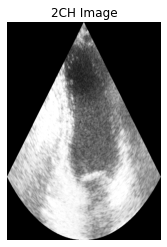

In [48]:
# Example usage
image_index = 0  # Choose an index to view a specific image from the sequence
image_data = sequence_2CH_mhd[image_index]  # Replace 'sequence_2CH_mhd' with the desired image data
view_image(image_data, title="2CH Image")


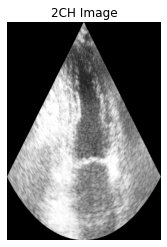

In [49]:
# Example usage -- index 0 to 17?
image_index = 17  # Choose an index to view a specific image from the sequence
image_data = sequence_2CH_mhd[image_index]  # Replace 'sequence_2CH_mhd' with the desired image data
view_image(image_data, title="2CH Image")